In [4]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


In [5]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


In [7]:
def get_irus_sampling_strategy(y):
    counts = Counter(y)
    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)
    imbalance_ratio = counts[majority_class] / counts[minority_class]
    
    # IRUS formula: inverse of square root of imbalance ratio
    sampling_ratio = 1 / np.sqrt(imbalance_ratio)
    
    # Calculate number of samples to keep for majority class
    n_samples_majority = int(counts[minority_class] / sampling_ratio)
    
    return {majority_class: n_samples_majority}

# Get IRUS sampling strategy based on training data
irus_strategy = get_irus_sampling_strategy(y_train)

# Define pipeline with IRUS and RFE for SVM
pipelineIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.7338709677419355

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.89      0.94      0.91        17
        Her2       1.00      0.43      0.60         7
        LumA       0.89      0.59      0.71        58
        LumB       0.48      0.88      0.62        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.73       124
   macro avg       0.82      0.76      0.75       124
weighted avg       0.81      0.73      0.74       124



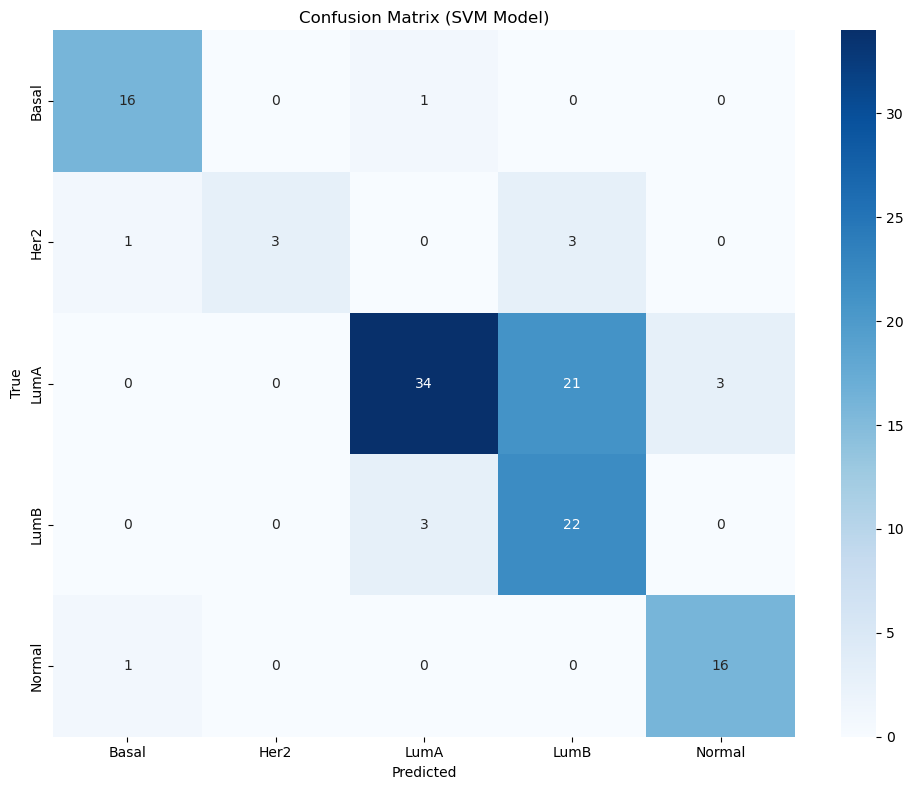

In [10]:
from sklearn.feature_selection import RFE
pipelineIrusSvmRfe = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


pipelineIrusSvmRfe.fit(X_train, y_train)
y_pred = pipelineIrusSvmRfe.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.7016129032258065

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.93      0.82      0.88        17
        Her2       0.67      0.57      0.62         7
        LumA       0.86      0.55      0.67        58
        LumB       0.50      0.84      0.63        25
      Normal       0.67      0.94      0.78        17

    accuracy                           0.70       124
   macro avg       0.73      0.75      0.71       124
weighted avg       0.76      0.70      0.70       124



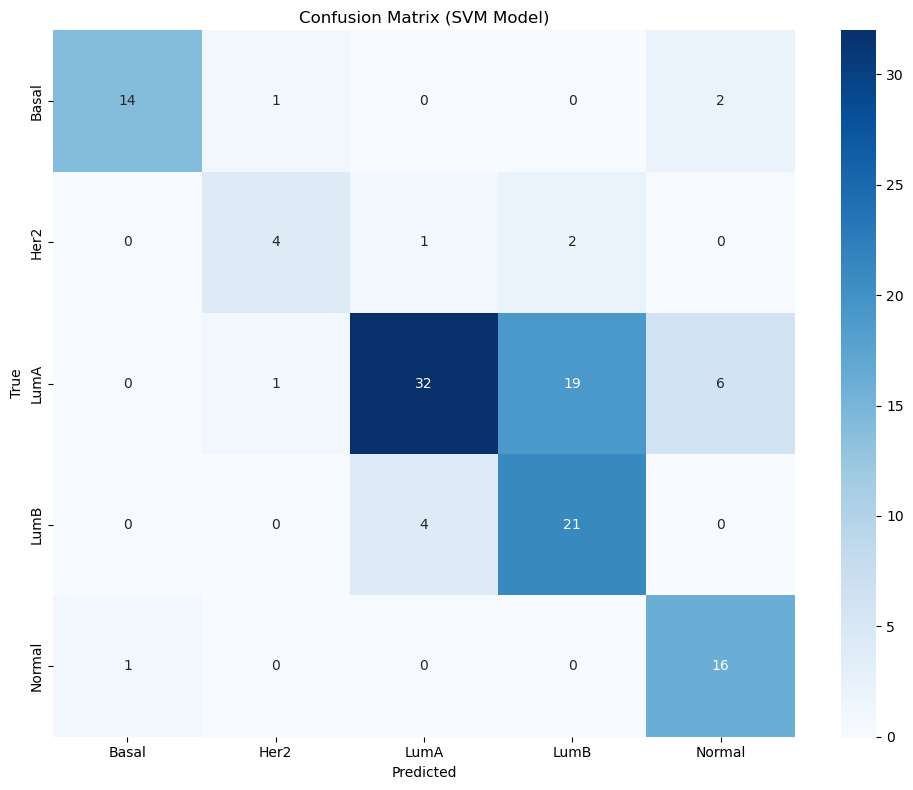

In [12]:
from sklearn.feature_selection import RFE
pipelineSvmRfe = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))  # Using SVC as the final classifier
])

pipelineSvmRfe.fit(X_train, y_train)
y_pred = pipelineSvmRfe.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.7096774193548387

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.93      0.82      0.88        17
        Her2       0.71      0.71      0.71         7
        LumA       0.86      0.55      0.67        58
        LumB       0.53      0.84      0.65        25
      Normal       0.64      0.94      0.76        17

    accuracy                           0.71       124
   macro avg       0.74      0.77      0.73       124
weighted avg       0.77      0.71      0.71       124



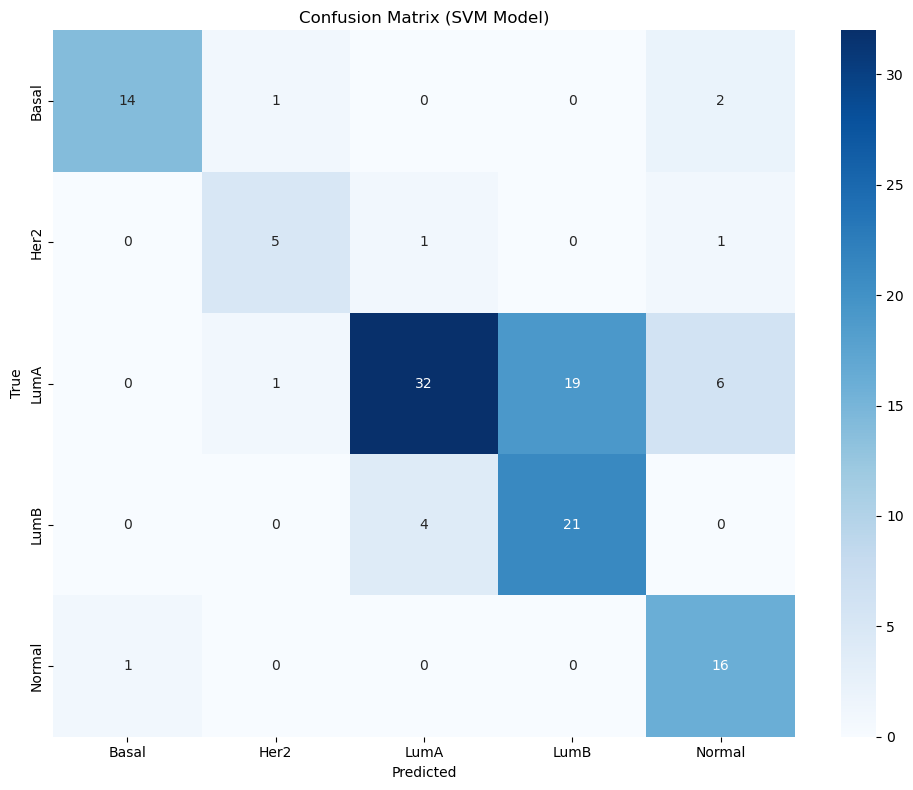

In [21]:
from sklearn.feature_selection import RFE
pipelineSvmRfe = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='poly', probability=True, random_state=42))  # Using SVC as the final classifier
])

pipelineSvmRfe.fit(X_train, y_train)
y_pred = pipelineSvmRfe.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.20161290322580644

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00        17
        Her2       0.00      0.00      0.00         7
        LumA       0.00      0.00      0.00        58
        LumB       0.20      1.00      0.34        25
      Normal       0.00      0.00      0.00        17

    accuracy                           0.20       124
   macro avg       0.04      0.20      0.07       124
weighted avg       0.04      0.20      0.07       124



C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


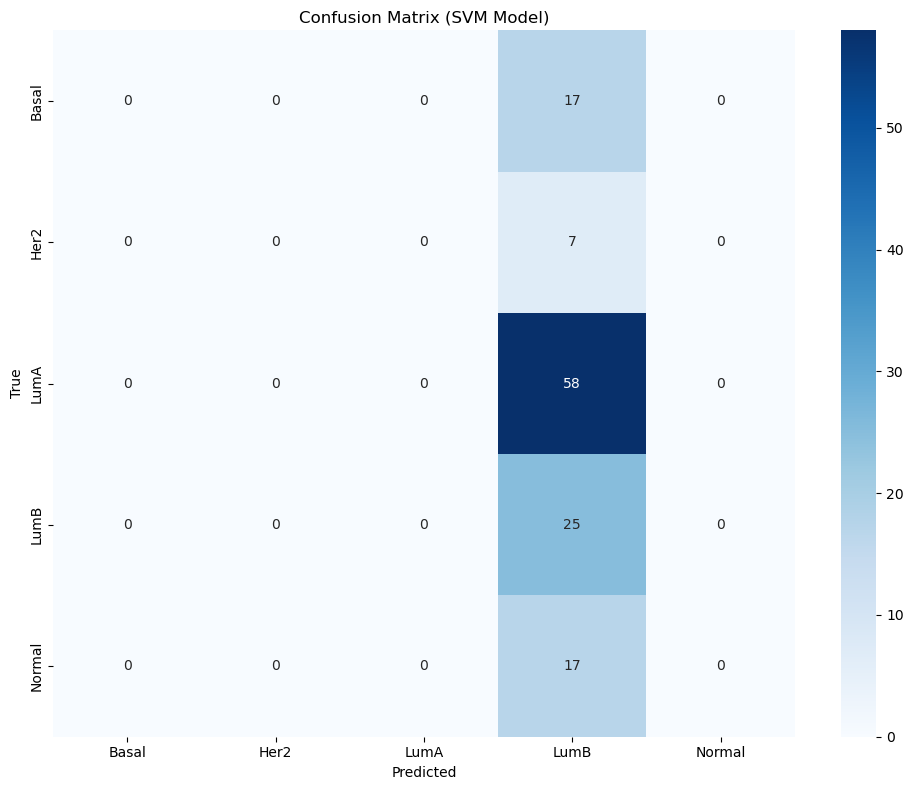

In [17]:
from sklearn.feature_selection import RFE
pipelineSvmRfe = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='sigmoid', probability=True, random_state=42))  # Using SVC as the final classifier
])

pipelineSvmRfe.fit(X_train, y_train)
y_pred = pipelineSvmRfe.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()